In [1]:
import os
import numpy as np
import pyccl as ccl
import healpy as hp
import matplotlib.pyplot as plt
from scipy.integrate import simps
from astropy.io import fits

Ngrid = 256
Lbox = 500.000 Mpc/h


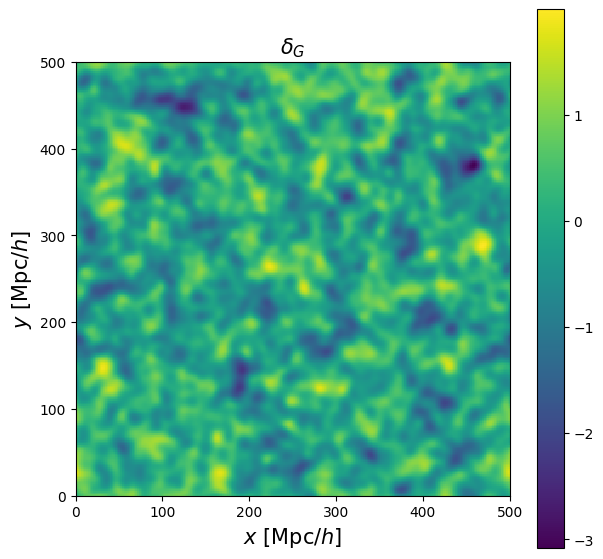

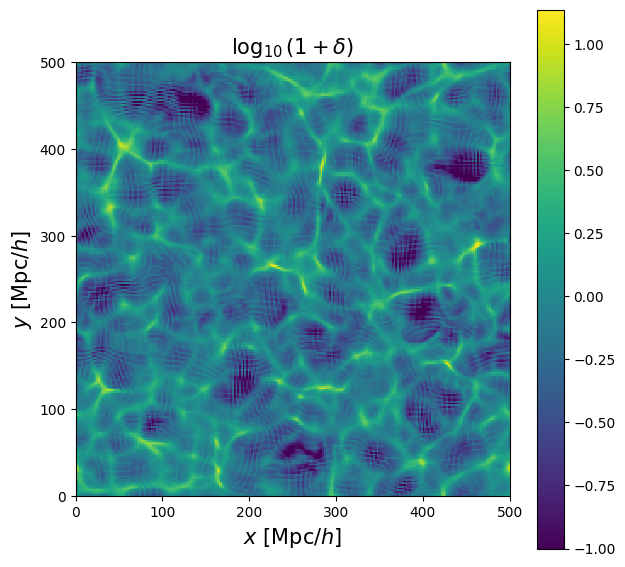

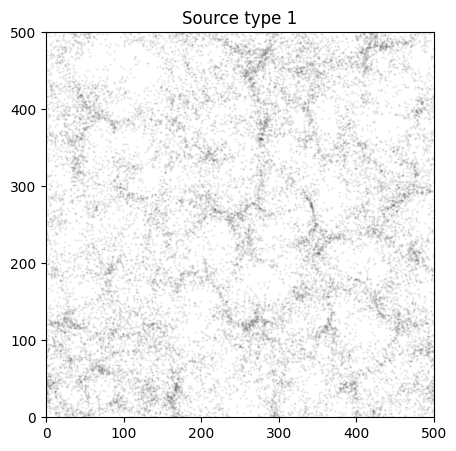

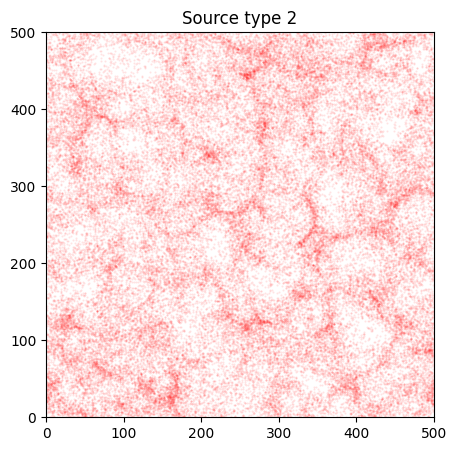

In [2]:
def read_grid(prefix):
    # This routine reads a 3D grid in CoLoRe's native format
    f = open(prefix+"_0.dat", "rb")
    nfiles, size_float = np.fromfile(f, dtype=np.int32, count=2)
    lbox = np.fromfile(f, dtype=np.float64, count=1)[0]
    ngrid = np.fromfile(f, dtype=np.int32, count=1)[0]
    f.close()

    if size_float == 4:
        f_type = np.float32
    else:
        f_type = np.float64

    grid_out = np.zeros([ngrid, ngrid, ngrid])
    for ifil in np.arange(nfiles):
        f = open(prefix+"_%d.dat" % ifil, "rb")
        nf, sz = np.fromfile(f, dtype=np.int32, count=2)
        _ = np.fromfile(f, dtype=np.float64, count=1)
        ng, nz_here, iz0_here = np.fromfile(f, dtype=np.int32, count=3)
        for iz in np.arange(nz_here):
            d = np.fromfile(f, dtype=f_type, count=ng*ng).reshape([ng, ng])
            grid_out[iz0_here+iz, :, :] = d
        f.close()

    return ngrid, lbox, np.array(grid_out)

# Read Gaussian field and non-linear field
ng, lb, dens = read_grid('test_out_dens_nonlinear')
_, _, densG = read_grid('test_out_dens_gaussian')
print("Ngrid = %d" % ng)
print("Lbox = %.3lf Mpc/h" % lb)


plt.figure(figsize=(7, 7))
plt.title(r'$\delta_G$', fontsize=15)
plt.imshow(densG[:, :, ng//2], origin='lower',
           interpolation='nearest',
           extent=[0, lb, 0, lb])
plt.colorbar()
plt.xlabel(r'$x\,\,[{\rm Mpc}/h]$', fontsize=15)
plt.ylabel(r'$y\,\,[{\rm Mpc}/h]$', fontsize=15);

plt.figure(figsize=(7, 7))
plt.title(r'$\log_{10}(1+\delta)$', fontsize=15)
plt.imshow(np.log10(1.001+dens[:, :, ng//2]),
           origin='lower',
           interpolation='nearest',
           vmin=-1, extent=[0, lb, 0, lb])
plt.colorbar()
plt.xlabel(r'$x\,\,[{\rm Mpc}/h]$', fontsize=15)
plt.ylabel(r'$y\,\,[{\rm Mpc}/h]$', fontsize=15)

# Read each catalog, select sources in a slab around
# the middle of the box, and plot them.
# They should track the same structures seen in the
# non-linear field.
for src, col in zip([1, 2], ['k', 'r']):
    cat = fits.open(f"test_out_srcs_s{src}_0.fits")[1].data
    igood = (cat['x']-lb/2 < lb/20) & (cat['x']-lb/2 > -lb/20)
    plt.figure(figsize=(5, 5))
    plt.title(f"Source type {src}")
    plt.plot(cat[igood]['y'], cat[igood]['z'], col+'.', ms=1, alpha=0.1)
    plt.xlim([0, lb])
    plt.ylim([0, lb])